# MEng-Team-Project-ML

This notebook contains the initial analysis of SQLite DB files generated \
by our ML system as of February 2022 (refer to git commit for exact \
version).

Each one of our key objectives is far easier to implement than before because\
the StrongSORT algorithm is very performant, and easy to calibrate for our use\
case.
- Object Identification 
  - This objective is the easiest to implement as we have the predicted \
    class along with it's bounding box per frame.
- Object Count
  - For this objective, we just count the number of unique IDs across time. The \
    lower the IDs (identity switching) and higher the AssA (association accuracy) \
    of our model for our dataset, the more reliable this object count will be, and \
    less post-processing of the analytics will be required.
- Object Tracking
  - For each object which is being successfully tracked and ID'd, we track its \
    detected anchor point from its bounding box across time and see which \
    boundaries of the video footage it's intersecting with, to \
    see which routes it's going from and to.

## Load Dataset

### Load COCO Classes

In [1]:
COCO_CLASSES = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' , 'hgv']

### Load Pre-Saved Analytical Dataset (SQLite)

In [55]:
# import os
# from traffic_ml.lib.gdrive import get_gdrive_id, download_file_from_google_drive

# TEST_FILE_FNAME = "test.db"
# TEST_FILE_LINK  = "https://drive.google.com/file/d/1EEiUSRbU8ehg_UaOJ5x9ci8DTOD-TqrA/view?usp=sharing"

# gdrive_id = get_gdrive_id(TEST_FILE_LINK)
# out = download_file_from_google_drive(gdrive_id, f"./{TEST_FILE_FNAME}")

# if os.path.exists(TEST_FILE_FNAME):
#     print("Downloaded successfully!")
# else:
#     print(f"Error downloading: {TEST_FILE_FNAME}")

## Data Analysis

### Load Mock Data into Dataframe (Long-Term Analysis-only)

In [2]:
"""
(successful) Mock long-term analysis data conditions:
- cols      := (frame, label, det_id, bbox_x, bbox_y, bbox_w, bbox_h)
- fps       := (1)
- timeframe := 60 secs
- busy times:
  - start (0 sec)
    - 10 cars   (going from south to north)
    - 10 bikes  (going from south to north)
    - 10 people (going from south to north)

demo situation:
- busy june saturday (3pm - rush hour)
- CAR
  - (west to east)
  - (east to west)
  - (south to east)
  - (some - north to south / south to north)
- PERSON
  - (all combos)
- BICYCLE
  - (all combos)
- HGV
  - (east to west, early in the morning - 8AM)
"""

import pandas as pd

cols = ["frame", "label", "det_id", "bbox_x", "bbox_y", "bbox_w", "bbox_h"]
data = {"car": {
        "West_Park_Road-East_Park_Road": {
            f"{16}-{17}": 13,
            f"{30}-{31}": 72,
            f"{42}-{43}": 20,
        },
        "East_Park_Road-West_Park_Road": {
            f"{16}-{17}": 12,
            f"{30}-{31}": 72,
            f"{42}-{43}": 35,
        },
        "South_Burnaby_Road-East_Park_Road": {
            f"{16}-{17}": 9,
            f"{30}-{31}": 20,
            f"{42}-{43}": 15,
        },
        "East_Park_Road-South_Burnaby_Road": {
            f"{16}-{17}": 13,
            f"{30}-{31}": 30,
            f"{42}-{43}": 23,
        },
        "North_Burnaby_Road-South_Burnaby_Road": {
            f"{16}-{17}": 8,
            f"{30}-{31}": 35,
            f"{42}-{43}": 6,
        },
        "South_Burnaby_Road-North_Burnaby_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 15,
            f"{42}-{43}": 25,
        },
        "South_Burnaby_Road-West_Park_Road": {
            f"{16}-{17}": 5,
            f"{30}-{31}": 15,
            f"{42}-{43}": 19,
        },
        "West_Park_Road-South_Burnaby_Road": {
            f"{16}-{17}": 13,
            f"{30}-{31}": 35,
            f"{42}-{43}": 22,
        },
        "North_Burnaby_Road-West_Park_Road": {
            f"{16}-{17}": 9,
            f"{30}-{31}": 32,
            f"{42}-{43}": 18,
        },
        "West_Park_Road-North_Burnaby_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 18,
            f"{42}-{43}": 10,
        },
        "North_Burnaby_Road-East_Park_Road": {
            f"{16}-{17}": 6,
            f"{30}-{31}": 25,
            f"{42}-{43}": 15,
        },
        "East_Park_Road-North_Burnaby_Road": {
            f"{16}-{17}": 7,
            f"{30}-{31}": 25,
            f"{42}-{43}": 15,
        },
        
    },
    "hgv": {
        "West_Park_Road-East_Park_Road": {
            f"{16}-{17}": 15,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "East_Park_Road-West_Park_Road": {
            f"{16}-{17}": 9,
            f"{30}-{31}": 45,
            f"{42}-{43}": 1,
        },
        "South_Burnaby_Road-East_Park_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "East_Park_Road-South_Burnaby_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "North_Burnaby_Road-South_Burnaby_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "South_Burnaby_Road-North_Burnaby_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "South_Burnaby_Road-West_Park_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "West_Park_Road-South_Burnaby_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "North_Burnaby_Road-West_Park_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "West_Park_Road-North_Burnaby_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "North_Burnaby_Road-East_Park_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
        "East_Park_Road-North_Burnaby_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 0,
            f"{42}-{43}": 0,
        },
    },
    "bicycle": {
        "West_Park_Road-East_Park_Road": {
            f"{16}-{17}": 5,
            f"{30}-{31}": 8,
            f"{42}-{43}": 0,
        },
        "East_Park_Road-West_Park_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 8,
            f"{42}-{43}": 0,
        },
        "South_Burnaby_Road-East_Park_Road": {
            f"{16}-{17}": 4,
            f"{30}-{31}": 3,
            f"{42}-{43}": 2,
        },
        "East_Park_Road-South_Burnaby_Road": {
            f"{16}-{17}": 2,
            f"{30}-{31}": 3,
            f"{42}-{43}": 0,
        },
        "North_Burnaby_Road-South_Burnaby_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 1,
            f"{42}-{43}": 3,
        },
        "South_Burnaby_Road-North_Burnaby_Road": {
            f"{16}-{17}": 1,
            f"{30}-{31}": 2,
            f"{42}-{43}": 0,
        },
        "South_Burnaby_Road-West_Park_Road": {
            f"{16}-{17}": 1,
            f"{30}-{31}": 0,
            f"{42}-{43}": 1,
        },
        "West_Park_Road-South_Burnaby_Road": {
            f"{16}-{17}": 4,
            f"{30}-{31}": 3,
            f"{42}-{43}": 3,
        },
        "North_Burnaby_Road-West_Park_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 1,
            f"{42}-{43}": 1,
        },
        "West_Park_Road-North_Burnaby_Road": {
            f"{16}-{17}": 2,
            f"{30}-{31}": 1,
            f"{42}-{43}": 1,
        },
        "North_Burnaby_Road-East_Park_Road": {
            f"{16}-{17}": 1,
            f"{30}-{31}": 3,
            f"{42}-{43}": 1,
        },
        "East_Park_Road-North_Burnaby_Road": {
            f"{16}-{17}": 5,
            f"{30}-{31}": 0,
            f"{42}-{43}": 2,
        },
    },
    "person": {
        "West_Park_Road-East_Park_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 50,
            f"{42}-{43}": 20,
        },
        "East_Park_Road-West_Park_Road": {
            f"{16}-{17}": 1,
            f"{30}-{31}": 70,
            f"{42}-{43}": 4,
        },
        "South_Burnaby_Road-East_Park_Road": {
            f"{16}-{17}": 6,
            f"{30}-{31}": 10,
            f"{42}-{43}": 11,
        },
        "East_Park_Road-South_Burnaby_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 15,
            f"{42}-{43}": 1,
        },
        "North_Burnaby_Road-South_Burnaby_Road": {
            f"{16}-{17}": 4,
            f"{30}-{31}": 10,
            f"{42}-{43}": 13,
        },
        "South_Burnaby_Road-North_Burnaby_Road": {
            f"{16}-{17}": 2,
            f"{30}-{31}": 12,
            f"{42}-{43}": 0,
        },
        "South_Burnaby_Road-West_Park_Road": {
            f"{16}-{17}": 2,
            f"{30}-{31}": 14,
            f"{42}-{43}": 8,
        },
        "West_Park_Road-South_Burnaby_Road": {
            f"{16}-{17}": 1,
            f"{30}-{31}": 8,
            f"{42}-{43}": 3,
        },
        "North_Burnaby_Road-West_Park_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 25,
            f"{42}-{43}": 9,
        },
        "West_Park_Road-North_Burnaby_Road": {
            f"{16}-{17}": 6,
            f"{30}-{31}": 7,
            f"{42}-{43}": 8,
        },
        "North_Burnaby_Road-East_Park_Road": {
            f"{16}-{17}": 0,
            f"{30}-{31}": 10,
            f"{42}-{43}": 5,
        },
        "East_Park_Road-North_Burnaby_Road": {
            f"{16}-{17}": 3,
            f"{30}-{31}": 10,
            f"{42}-{43}": 0,
        },
    }
}

region_coord = {
    "None":               { "x": 100, "y": 100, "w": 10, "h": 10 },
    "South_Burnaby_Road": { "x": 0,   "y": 0,   "w": 10, "h": 10  },
    "North_Burnaby_Road": { "x": 50,  "y": 50,  "w": 10, "h": 10  },
    "West_Park_Road":     { "x": 20,  "y": 20,  "w": 10, "h": 10  },
    "East_Park_Road":     { "x": 70,  "y": 70,  "w": 10, "h": 10  },
}

rows = []

det_id_counter = 0
for obj, routes in data.items():
    for route, tm_counts in routes.items():
        start_route, end_route = route.split("-")
        for tm, count in tm_counts.items():
            start_tm, end_tm = tm.split("-")
            start_tm = float(start_tm) * (0.5 * 3600)
            end_tm   = float(end_tm) * (0.5 * 3600)   - 10  # NOTE: -10 to respect boundaries of microservice
            # print(obj, start_route, end_route, start_tm, end_tm, count)

            start_x, start_y, start_w, start_h = region_coord[start_route]
            end_x, end_y, end_w, end_h         = region_coord[end_route]
            for _ in range(count):
                start_frame = [start_tm, obj, det_id_counter] + list(region_coord[start_route].values()) #+ [start_route]
                end_frame   = [end_tm, obj, det_id_counter]   + list(region_coord[end_route].values())   #+ [end_route]
                det_id_counter += 1
                rows.append(start_frame)
                rows.append(end_frame)
    

# for tm in tm_step:
#     for r_idx, region_pair in enumerate(region_pairs):
#         for i, (lbl, count) in enumerate(zip(entries, entry_counts)):
#             for c in range(count):
#                 start_region_data, end_region_data = region_pair
#                 start_region_label, start_region_frame = start_region_data[0], start_region_data[1]
#                 end_region_label, end_region_frame = end_region_data[0], end_region_data[1]

#                 cur_label = None
#                 if tm == start_region_frame:
#                     cur_label = start_region_label
#                 elif tm == end_region_frame:
#                     cur_label = end_region_label
#                 else:
#                     cur_label = "None"

#                 cur_region_data = region_coord[cur_label]
#                 x, y, w, h = cur_region_data["x"], cur_region_data["y"], cur_region_data["w"], cur_region_data["h"]
#                 det_id = (c + i * count) + (r_idx * sum(entry_counts) * len(tm_step))
#                 #print("tm, lbl, c, i, count, det_id:", tm, lbl, c, i, count, det_id)
#                 rows.append([tm, lbl, det_id, x, y, w, h, cur_label])



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

detections_df = pd.DataFrame(data=rows, columns=cols)
detections_df = detections_df.sort_values(by=["frame", "det_id"])
# display(detections_df)

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 60)

In [3]:
detections_df.dtypes

frame     float64
label      object
det_id      int64
bbox_x      int64
bbox_y      int64
bbox_w      int64
bbox_h      int64
dtype: object

In [4]:
detections_df.shape, detections_df.columns

((2452, 7),
 Index(['frame', 'label', 'det_id', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h'], dtype='object'))

In [5]:
detections_df.tail()

,frame,label,det_id,bbox_x,bbox_y,bbox_w,bbox_h
2417,77390.0,person,1208,70,70,10,10
2419,77390.0,person,1209,70,70,10,10
2421,77390.0,person,1210,70,70,10,10
2423,77390.0,person,1211,70,70,10,10
2425,77390.0,person,1212,70,70,10,10


### Convert DataFrame

In [6]:
mock_long_df = detections_df.copy()
mock_long_df["cls"] = mock_long_df["label"].apply(lambda lbl: float(COCO_CLASSES.index(lbl)))
mock_long_df["conf"] = mock_long_df["label"].apply(lambda _: 1.0)

In [7]:
mock_long_df

,frame,label,det_id,bbox_x,bbox_y,bbox_w,bbox_h,cls,conf
0,28800.0,car,0,20,20,10,10,2.0,1.0
2,28800.0,car,1,20,20,10,10,2.0,1.0
4,28800.0,car,2,20,20,10,10,2.0,1.0
6,28800.0,car,3,20,20,10,10,2.0,1.0
8,28800.0,car,4,20,20,10,10,2.0,1.0
...,...,...,...,...,...,...,...,...,...
2417,77390.0,person,1208,70,70,10,10,0.0,1.0
2419,77390.0,person,1209,70,70,10,10,0.0,1.0
2421,77390.0,person,1210,70,70,10,10,0.0,1.0
2423,77390.0,person,1211,70,70,10,10,0.0,1.0


In [8]:
import sqlite3
import pandas as pd

# assuming you already have a DataFrame named df

# Create a connection
conn = sqlite3.connect('mock_long.db')

# Write the data from df into a table called detections
mock_long_df.to_sql('detection', conn, if_exists='replace', index=False)

# Now let's create another table called metadata with the given specifications
# We'll create a DataFrame for this

data = {'id': [1],
        'width': [1920],
        'height': [1080],
        'fps': [1]}

metadata_df = pd.DataFrame(data)

# Write the data from metadata_df into a table called metadata
metadata_df.to_sql('metadata', conn, if_exists='replace', index=False)

# Close the connection
conn.close()
# mock_long_df.

### Load Data into Dataframe

In [62]:
# import sqlite3
# import pandas as pd
# groundTruthsData = True

# if not groundTruthsData:
#     # NOTE: Overwrite this for a local analysis
#     # TEST_FILE_FNAME = "night_test.db"
#     TEST_FILE_FNAME = "test_sz_640_stride_5_model_yolov8s-pt_tracker_ocsort.db"
#     con = sqlite3.connect(TEST_FILE_FNAME)

#     # Detected Objects per Frame
#     detections_df = pd.read_sql_query("SELECT * FROM detection;", con)

#     con.close()
# else:
#     detections_df = pd.read_csv('test_ground_truth.csv')
#     detections_df = detections_df.reindex(columns=['frame', 'label', 'det_id', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h'])
    
# detections_df


### Detection Count (per Frame)

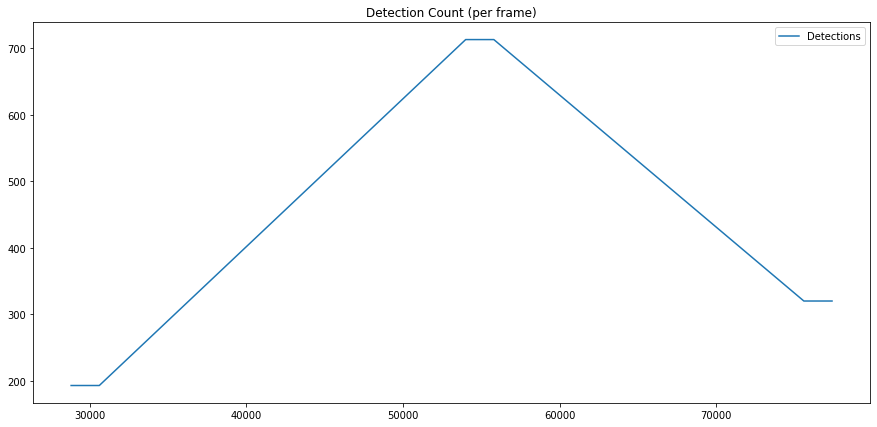

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

# Use frame or timestamp where they exist
if 'frame' not in detections_df.columns:
    det_count = detections_df["timestamp"]
    det_count = det_count.apply(lambda timestamp: timestamp.float_timestamp)
    print(det_count)
    det_count = det_count.value_counts().sort_index()
else:
    det_count = detections_df['frame'].value_counts().sort_index()

plt.title(f"Detection Count (per frame)")
plt.plot(det_count, label="Detections")

plt.legend()

### Change Frames to Timestamps

In [15]:
import arrow

temporal_resolution = "minute"
timestampShiftMultiplier = 1
if temporal_resolution == "second":
    timestampShiftMultiplier *= 1
elif temporal_resolution == "minute":
    timestampShiftMultiplier *= 60
elif temporal_resolution == "hour":
    timestampShiftMultiplier *= 3600
elif temporal_resolution == "day":
    timestampShiftMultiplier *= 86400
intervalSpacing = 30

# STARTTIME = arrow.get('2023-01-20T152442.922') # Manual Timestamp
STARTTIME = arrow.get('2023-01-20T00:00:00') # Manual Timestamp
# STARTTIME.shift(minutes=1)
FPS = 1

def newTimestamp(timestamp, frame, fps):
    shiftVal = (1000000/fps * frame)
    print(shiftVal)
    return timestamp.shift(microseconds=shiftVal)

# Change frames to timestamps
detections_df['frame'] = detections_df.apply(
    lambda row: newTimestamp(STARTTIME, int(row["frame"]), FPS), 
    axis=1
)
detections_df = detections_df.rename(columns={'frame':'timestamp'})

28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
28800000000.0
288000

In [16]:
detections_df

,timestamp,label,det_id,bbox_x,bbox_y,bbox_w,bbox_h
0,2023-01-20T08:00:00+00:00,car,0,20,20,10,10
2,2023-01-20T08:00:00+00:00,car,1,20,20,10,10
4,2023-01-20T08:00:00+00:00,car,2,20,20,10,10
6,2023-01-20T08:00:00+00:00,car,3,20,20,10,10
8,2023-01-20T08:00:00+00:00,car,4,20,20,10,10
...,...,...,...,...,...,...,...
2417,2023-01-20T21:30:00+00:00,person,1208,70,70,10,10
2419,2023-01-20T21:30:00+00:00,person,1209,70,70,10,10
2421,2023-01-20T21:30:00+00:00,person,1210,70,70,10,10
2423,2023-01-20T21:30:00+00:00,person,1211,70,70,10,10


In [17]:
detections_df["timestamp"].unique()

array([<Arrow [2023-01-20T08:00:00+00:00]>,
       <Arrow [2023-01-20T08:30:00+00:00]>,
       <Arrow [2023-01-20T15:00:00+00:00]>,
       <Arrow [2023-01-20T15:30:00+00:00]>,
       <Arrow [2023-01-20T21:00:00+00:00]>,
       <Arrow [2023-01-20T21:30:00+00:00]>], dtype=object)

### Object Count

In [18]:
data = detections_df

In [19]:
counts = data.groupby('label')['det_id'].nunique().reset_index(name='count')

In [20]:
counts

,label,count
0,bicycle,81
1,car,718
2,hgv,70
3,person,357


### Object Tracking

In [21]:
routes_df = data[["timestamp", "label", "det_id", "bbox_x", "bbox_y", "bbox_w", "bbox_h"]].copy()
routes_df["anchor_x"] = routes_df.apply(
    lambda row: row["bbox_x"] + (row["bbox_w"] / 2.0), axis=1)
routes_df["anchor_y"] = routes_df.apply(
    lambda row: row["bbox_y"] + (row["bbox_h"] / 2.0), axis=1)

In [22]:
routes_df

,timestamp,label,det_id,bbox_x,bbox_y,bbox_w,bbox_h,anchor_x,anchor_y
0,2023-01-20T08:00:00+00:00,car,0,20,20,10,10,25.0,25.0
2,2023-01-20T08:00:00+00:00,car,1,20,20,10,10,25.0,25.0
4,2023-01-20T08:00:00+00:00,car,2,20,20,10,10,25.0,25.0
6,2023-01-20T08:00:00+00:00,car,3,20,20,10,10,25.0,25.0
8,2023-01-20T08:00:00+00:00,car,4,20,20,10,10,25.0,25.0
...,...,...,...,...,...,...,...,...,...
2417,2023-01-20T21:30:00+00:00,person,1208,70,70,10,10,75.0,75.0
2419,2023-01-20T21:30:00+00:00,person,1209,70,70,10,10,75.0,75.0
2421,2023-01-20T21:30:00+00:00,person,1210,70,70,10,10,75.0,75.0
2423,2023-01-20T21:30:00+00:00,person,1211,70,70,10,10,75.0,75.0


#### Either First and Last, or all Anchor Points for Each (label, det_id) Tuple

In [23]:
def get_values(group):
    return group[['anchor_x', 'anchor_y']].values.tolist()

entire_routes = routes_df.groupby(['label', 'det_id']).apply(get_values)

In [24]:
entire_routes

label    det_id
bicycle  788       [[25.0, 25.0], [75.0, 75.0]]
         789       [[25.0, 25.0], [75.0, 75.0]]
         790       [[25.0, 25.0], [75.0, 75.0]]
         791       [[25.0, 25.0], [75.0, 75.0]]
         792       [[25.0, 25.0], [75.0, 75.0]]
                               ...             
person   1221      [[75.0, 75.0], [55.0, 55.0]]
         1222      [[75.0, 75.0], [55.0, 55.0]]
         1223      [[75.0, 75.0], [55.0, 55.0]]
         1224      [[75.0, 75.0], [55.0, 55.0]]
         1225      [[75.0, 75.0], [55.0, 55.0]]
Length: 1226, dtype: object

In [25]:
import json
trk_fmt = "first_last"

def get_values(group, trk_fmt):
    vals = group[['timestamp', 'anchor_x', 'anchor_y']].values.tolist()
    if trk_fmt == "first_last":
        vals = [vals[0], vals[-1]]
    vals = [{"timestamp": val[0], "x": val[1], "y": val[2]} for val in vals]
    return vals

routes = routes_df.groupby(['label', 'det_id']).apply(
            lambda group: get_values(group, trk_fmt))

# Reset the index of the resulting series to remove the MultiIndex
routes = routes.reset_index()

# Replace the MultiIndex label column names with 'label' and 'det_id'
routes.rename(columns={0: 'routes'}, inplace=True)
routes.rename(columns={'level_0': 'label', 'level_1': 'det_id'}, inplace=True)

# Create a dictionary with 'label' as the key and 'routes' as the value
route_endpoints = routes.groupby('label')['routes'].apply(list)

# Separate raw data and analytical data
final_data = {
    "counts": json.loads(counts.to_json(orient="records")),
    "routes": route_endpoints
}

In [26]:
route_endpoints

label
bicycle    [[{'timestamp': 2023-01-20T08:00:00+00:00, 'x'...
car        [[{'timestamp': 2023-01-20T08:00:00+00:00, 'x'...
hgv        [[{'timestamp': 2023-01-20T08:00:00+00:00, 'x'...
person     [[{'timestamp': 2023-01-20T08:00:00+00:00, 'x'...
Name: routes, dtype: object

### Object Routes

#### Route Region (Region Visualisation)

Following route regions for Park Rd East, Burnaby Rd South and Park Rd West, respectively (relative to junction)
<div>
<img src="route_regions.png" width="500"/>
</div>

#### Route Region (Polygon Data)

In [27]:
ROUTE_REGIONS = {}

for region_coord_c in region_coord.keys():
    cur_region_coord = region_coord[region_coord_c]
    x, y, w, h = cur_region_coord["x"], cur_region_coord["y"], cur_region_coord["w"], cur_region_coord["h"]
    lst_of_coords = [
        [x-w, y-h],
        [x+w, y-h],
        [x+w, y+h],
        [x-w, y+h],
        [x-w, y-h]
    ]
    ROUTE_REGIONS[region_coord_c] = lst_of_coords

In [28]:
ROUTE_REGIONS

{'None': [[90, 90], [110, 90], [110, 110], [90, 110], [90, 90]],
 'South_Burnaby_Road': [[-10, -10],
  [10, -10],
  [10, 10],
  [-10, 10],
  [-10, -10]],
 'North_Burnaby_Road': [[40, 40], [60, 40], [60, 60], [40, 60], [40, 40]],
 'West_Park_Road': [[10, 10], [30, 10], [30, 30], [10, 30], [10, 10]],
 'East_Park_Road': [[60, 60], [80, 60], [80, 80], [60, 80], [60, 60]]}

In [29]:
ROUTE_REGIONS.keys()

dict_keys(['None', 'South_Burnaby_Road', 'North_Burnaby_Road', 'West_Park_Road', 'East_Park_Road'])

In [30]:
  
# # Original Regions (working with GT)
# ROUTE_REGIONS = {
#     "North_Burnaby_Road": [
#         [
#             1074.9999999999611,
#             759.0000000004657
#         ],
#         [
#             1395.9999999999611,
#             1060.0000000006207
#         ],
#         [
#             1903.999999999573,
#             1067
#         ],
#         [
#             1903.999999999573,
#             584
#         ],
#         [
#             1515.9999999998836,
#             495.00000000046566
#         ],
#         [
#             1074.9999999999611,
#             759.0000000004657
#         ]
#     ],
#     "East_Park_Road": [
#         [
#             732.9999999999611,
#             456.00000000062084
#         ],
#         [
#             492.9999999998836,
#             314
#         ],
#         [
#             490.99999999972835,
#             7.000000000931323
#         ],
#         [
#             0.9999999999611948,
#             3.0000000003104406
#         ],
#         [
#             0.9999999999611948,
#             1075.9999999996894
#         ],
#         [
#             1378.9999999997283,
#             1067
#         ],
#         [
#             732.9999999999611,
#             456.00000000062084
#         ]
#     ],
#     "South_Burnaby_Road": [
#         [
#             1107.9999999998058,
#             376.00000000124174
#         ],
#         [
#             1120.9999999996508,
#             1.0000000012417634
#         ],
#         [
#             501.9999999998836,
#             7.000000000931323
#         ],
#         [
#             504.9999999998836,
#             309.0000000003104
#         ],
#         [
#             748.9999999996508,
#             450.00000000062084
#         ],
#         [
#             1107.9999999998058,
#             376.00000000124174
#         ]
#     ],
#     "West_Park_Road": [
#         [
#             1127.9999999998058,
#             391.0000000009313
#         ],
#         [
#             1911.9999999998058,
#             575
#         ],
#         [
#             1907.9999999998836,
#             165.00000000046566
#         ],
#         [
#             1864.9999999997672,
#             11
#         ],
#         [
#             1137.9999999998836,
#             7.000000000931323
#         ],
#         [
#             1127.9999999998058,
#             391.0000000009313
#         ]
#     ]
# 


### Object Tracking (Start and Finish Regions)

Total number of (start, end) tuples := n * (n - 1), where n is the number of unique route regions. \
For example in the image above, there are 3 route regions (Park W, Park E, Burnaby S). \
So the total number of unique paths for an object is 3 * (3 - 1) => 3 * 2 => 6.

In [31]:
from shapely.geometry import Point, Polygon

# 1. Get start and end pos for each unique object during entire video
start_end_df = entire_routes.copy()
start_end_df = start_end_df.reset_index()

overlap_start_df = start_end_df.copy()[["label", "det_id"]]
overlap_end_df = start_end_df.copy()[["label", "det_id"]]

start_end_df["start_x"] = start_end_df.apply(lambda row: row[0][0][0],  axis=1)
start_end_df["start_y"] = start_end_df.apply(lambda row: row[0][0][1],  axis=1)
start_end_df["end_x"]   = start_end_df.apply(lambda row: row[0][-1][0], axis=1)
start_end_df["end_y"]   = start_end_df.apply(lambda row: row[0][-1][1], axis=1)
if 0 in start_end_df:
    del start_end_df[0]

region_polys = {}

# 2. Get overlaps between start and end, and each region
for route_region in ROUTE_REGIONS.keys():
    cur_polygon = Polygon(ROUTE_REGIONS[route_region])
    region_polys[route_region] = cur_polygon

    # Start Geometry
    start_geometry = [Point(x, y) for x, y in zip(start_end_df["start_x"], start_end_df["start_y"])]

    # Start Overlap
    start_end_df[f"{route_region}_start_overlap"] = [point.within(cur_polygon) for point in start_geometry]
    overlap_start_df[route_region]                = start_end_df[f"{route_region}_start_overlap"]

    # End Geometry
    end_geometry = [Point(x, y) for x, y in zip(start_end_df["end_x"], start_end_df["end_y"])]

    # End Overlap
    start_end_df[f"{route_region}_end_overlap"] = [point.within(cur_polygon) for point in end_geometry]
    overlap_end_df[route_region]                = start_end_df[f"{route_region}_end_overlap"]

In [32]:
start_end_df

,label,det_id,start_x,start_y,end_x,end_y,None_start_overlap,None_end_overlap,South_Burnaby_Road_start_overlap,South_Burnaby_Road_end_overlap,North_Burnaby_Road_start_overlap,North_Burnaby_Road_end_overlap,West_Park_Road_start_overlap,West_Park_Road_end_overlap,East_Park_Road_start_overlap,East_Park_Road_end_overlap
0,bicycle,788,25.0,25.0,75.0,75.0,False,False,False,False,False,False,True,False,False,True
1,bicycle,789,25.0,25.0,75.0,75.0,False,False,False,False,False,False,True,False,False,True
2,bicycle,790,25.0,25.0,75.0,75.0,False,False,False,False,False,False,True,False,False,True
3,bicycle,791,25.0,25.0,75.0,75.0,False,False,False,False,False,False,True,False,False,True
4,bicycle,792,25.0,25.0,75.0,75.0,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,person,1221,75.0,75.0,55.0,55.0,False,False,False,False,False,True,False,False,True,False
1222,person,1222,75.0,75.0,55.0,55.0,False,False,False,False,False,True,False,False,True,False
1223,person,1223,75.0,75.0,55.0,55.0,False,False,False,False,False,True,False,False,True,False
1224,person,1224,75.0,75.0,55.0,55.0,False,False,False,False,False,True,False,False,True,False


#### Determine (Start, End) Tuples

In [33]:
overlap_start_df.head(20)

,label,det_id,None,South_Burnaby_Road,North_Burnaby_Road,West_Park_Road,East_Park_Road
0,bicycle,788,False,False,False,True,False
1,bicycle,789,False,False,False,True,False
2,bicycle,790,False,False,False,True,False
3,bicycle,791,False,False,False,True,False
4,bicycle,792,False,False,False,True,False
5,bicycle,793,False,False,False,True,False
6,bicycle,794,False,False,False,True,False
7,bicycle,795,False,False,False,True,False
8,bicycle,796,False,False,False,True,False
9,bicycle,797,False,False,False,True,False


#### Determine Start Label

In [34]:
import numpy as np

def label_overlap(row):
    for i in range(len(row)):
        if row[i]:
            return overlap_start_df.columns[2:][i]
    return np.nan

overlap_start_df['overlap_label'] = overlap_start_df.iloc[:, 2:].apply(label_overlap, axis=1)

In [35]:
overlap_start_df

,label,det_id,None,South_Burnaby_Road,North_Burnaby_Road,West_Park_Road,East_Park_Road,overlap_label
0,bicycle,788,False,False,False,True,False,West_Park_Road
1,bicycle,789,False,False,False,True,False,West_Park_Road
2,bicycle,790,False,False,False,True,False,West_Park_Road
3,bicycle,791,False,False,False,True,False,West_Park_Road
4,bicycle,792,False,False,False,True,False,West_Park_Road
...,...,...,...,...,...,...,...,...
1221,person,1221,False,False,False,False,True,East_Park_Road
1222,person,1222,False,False,False,False,True,East_Park_Road
1223,person,1223,False,False,False,False,True,East_Park_Road
1224,person,1224,False,False,False,False,True,East_Park_Road


#### Determine End Label

In [36]:
import numpy as np

def label_overlap(row):
    for i in range(len(row)):
        if row[i]:
            return overlap_end_df.columns[2:][i]
    return np.nan

overlap_end_df['overlap_label'] = overlap_end_df.iloc[:, 2:].apply(label_overlap, axis=1)

In [37]:
overlap_end_df.head(20)

,label,det_id,None,South_Burnaby_Road,North_Burnaby_Road,West_Park_Road,East_Park_Road,overlap_label
0,bicycle,788,False,False,False,False,True,East_Park_Road
1,bicycle,789,False,False,False,False,True,East_Park_Road
2,bicycle,790,False,False,False,False,True,East_Park_Road
3,bicycle,791,False,False,False,False,True,East_Park_Road
4,bicycle,792,False,False,False,False,True,East_Park_Road
5,bicycle,793,False,False,False,False,True,East_Park_Road
6,bicycle,794,False,False,False,False,True,East_Park_Road
7,bicycle,795,False,False,False,False,True,East_Park_Road
8,bicycle,796,False,False,False,False,True,East_Park_Road
9,bicycle,797,False,False,False,False,True,East_Park_Road


#### Create Final Overlap DataFrame

In [38]:
overlap_df = start_end_df.iloc[:, :2]
overlap_df["start"] = overlap_start_df["overlap_label"]
overlap_df["end"]   = overlap_end_df["overlap_label"]

In [39]:
overlap_df

,label,det_id,start,end
0,bicycle,788,West_Park_Road,East_Park_Road
1,bicycle,789,West_Park_Road,East_Park_Road
2,bicycle,790,West_Park_Road,East_Park_Road
3,bicycle,791,West_Park_Road,East_Park_Road
4,bicycle,792,West_Park_Road,East_Park_Road
...,...,...,...,...
1221,person,1221,East_Park_Road,North_Burnaby_Road
1222,person,1222,East_Park_Road,North_Burnaby_Road
1223,person,1223,East_Park_Road,North_Burnaby_Road
1224,person,1224,East_Park_Road,North_Burnaby_Road


### Finding Times Spent in and Out of Regions

#### Organise Route Boundary DataFrame

In [40]:
def get_values(group):
    return group[['timestamp','anchor_x', 'anchor_y']].values.tolist()

route_boundaries_df = routes_df.groupby(['label', 'det_id']).apply(get_values)
route_boundaries_df = pd.DataFrame(route_boundaries_df.reset_index(name='route'))
route_boundaries_df

,label,det_id,route
0,bicycle,788,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202..."
1,bicycle,789,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202..."
2,bicycle,790,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202..."
3,bicycle,791,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202..."
4,bicycle,792,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202..."
...,...,...,...
1221,person,1221,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202..."
1222,person,1222,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202..."
1223,person,1223,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202..."
1224,person,1224,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202..."


In [41]:
# Add region names from overlap_df
route_boundaries_df = pd.merge(route_boundaries_df, overlap_df, on=['label', 'det_id'])
route_boundaries_df.rename(columns={'start':'start_region', 'end':'end_region'}, inplace=True)
entire_routes = route_boundaries_df.copy()

In [42]:
region_polys

{'None': <POLYGON ((90 90, 110 90, 110 110, 90 110, 90 90))>,
 'South_Burnaby_Road': <POLYGON ((-10 -10, 10 -10, 10 10, -10 10, -10 -10))>,
 'North_Burnaby_Road': <POLYGON ((40 40, 60 40, 60 60, 40 60, 40 40))>,
 'West_Park_Road': <POLYGON ((10 10, 30 10, 30 30, 10 30, 10 10))>,
 'East_Park_Road': <POLYGON ((60 60, 80 60, 80 80, 60 80, 60 60))>}

#### Arrange Start and End Points

In [43]:
route_boundaries_df['start_point'] = route_boundaries_df['route'].apply(lambda route: route[0])
route_boundaries_df['end_point'] = route_boundaries_df['route'].apply(lambda route: route[-1])
route_boundaries_df

,label,det_id,route,start_region,end_region,start_point,end_point
0,bicycle,788,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
1,bicycle,789,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
2,bicycle,790,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
3,bicycle,791,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
4,bicycle,792,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
...,...,...,...,...,...,...,...
1221,person,1221,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]"
1222,person,1222,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]"
1223,person,1223,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]"
1224,person,1224,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]"


#### Find Starting Region Boundary

In [44]:
def findFirstRegionBoundary(vals):
    initialRegion = which_region(Point(*vals[0][1:]))

    if initialRegion is None: return None
    
    # Binary search for boundary point
    pointRange = vals
    while len(pointRange) > 1:

        midIndex = round(len(pointRange)/2)
        midpoint = pointRange[midIndex]
        regionCheck = which_region(Point(*midpoint[1:]))

        if regionCheck == initialRegion:
            pointRange = pointRange[midIndex:] # go right
        else:
            pointRange = pointRange[:midIndex] # go left
    
    if len(pointRange) != 0: return pointRange[0]

def which_region(point):
    for label, poly in region_polys.items():
        if point.within(poly):
            return label

route_boundaries_df['start_boundary'] = route_boundaries_df['route'].apply(findFirstRegionBoundary)


In [45]:
route_boundaries_df

,label,det_id,route,start_region,end_region,start_point,end_point,start_boundary
0,bicycle,788,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]"
1,bicycle,789,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]"
2,bicycle,790,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]"
3,bicycle,791,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]"
4,bicycle,792,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]"
...,...,...,...,...,...,...,...,...
1221,person,1221,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]"
1222,person,1222,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]"
1223,person,1223,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]"
1224,person,1224,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]"


#### Find Ending Region Boundary

In [46]:
def findEndRegionBoundary(start_region, end_region, route):
    if start_region == end_region:
        return None
    else:
        return findFirstRegionBoundary(route[::-1])

# Reverse the list and find the end region boundary
route_boundaries_df['end_boundary'] = route_boundaries_df.apply(
    lambda row: findEndRegionBoundary(row['start_region'], row['end_region'], row['route']),
    axis=1
)
route_boundaries_df

,label,det_id,route,start_region,end_region,start_point,end_point,start_boundary,end_boundary
0,bicycle,788,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
1,bicycle,789,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
2,bicycle,790,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
3,bicycle,791,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
4,bicycle,792,"[[2023-01-20T08:00:00+00:00, 25.0, 25.0], [202...",West_Park_Road,East_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]"
...,...,...,...,...,...,...,...,...,...
1221,person,1221,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]"
1222,person,1222,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]"
1223,person,1223,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]"
1224,person,1224,"[[2023-01-20T15:00:00+00:00, 75.0, 75.0], [202...",East_Park_Road,North_Burnaby_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]"


#### Organise Dataframe

In [47]:
# Reorder columns
route_boundaries_df = route_boundaries_df.reindex(columns=['label', 'det_id', 'start_region', 'start_point', 'start_boundary', 'end_boundary', 'end_point', 'end_region'])
route_boundaries_df
route_boundaries_df.loc[route_boundaries_df['label'] == 'car']

,label,det_id,start_region,start_point,start_boundary,end_boundary,end_point,end_region
81,car,0,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road
82,car,1,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road
83,car,2,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road
84,car,3,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road
85,car,4,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road
...,...,...,...,...,...,...,...,...
794,car,713,East_Park_Road,"[2023-01-20T21:00:00+00:00, 75.0, 75.0]","[2023-01-20T21:00:00+00:00, 75.0, 75.0]","[2023-01-20T21:30:00+00:00, 55.0, 55.0]","[2023-01-20T21:30:00+00:00, 55.0, 55.0]",North_Burnaby_Road
795,car,714,East_Park_Road,"[2023-01-20T21:00:00+00:00, 75.0, 75.0]","[2023-01-20T21:00:00+00:00, 75.0, 75.0]","[2023-01-20T21:30:00+00:00, 55.0, 55.0]","[2023-01-20T21:30:00+00:00, 55.0, 55.0]",North_Burnaby_Road
796,car,715,East_Park_Road,"[2023-01-20T21:00:00+00:00, 75.0, 75.0]","[2023-01-20T21:00:00+00:00, 75.0, 75.0]","[2023-01-20T21:30:00+00:00, 55.0, 55.0]","[2023-01-20T21:30:00+00:00, 55.0, 55.0]",North_Burnaby_Road
797,car,716,East_Park_Road,"[2023-01-20T21:00:00+00:00, 75.0, 75.0]","[2023-01-20T21:00:00+00:00, 75.0, 75.0]","[2023-01-20T21:30:00+00:00, 55.0, 55.0]","[2023-01-20T21:30:00+00:00, 55.0, 55.0]",North_Burnaby_Road


#### Workout Times Spent in Each Region From Timestamps

In [48]:
route_times_df = route_boundaries_df.copy()

def find_time(start_boundary, end_boundary):
    if start_boundary is None or end_boundary is None: 
        return None
    else:
        return end_boundary[0] - start_boundary[0]

# Time spent overall in the route
route_times_df['overall_time'] = route_times_df.apply(
    lambda row: row['end_point'][0] - row['start_point'][0], 
    axis=1
)
# Time spent in first region
route_times_df['start_region_time'] = route_times_df.apply(
    lambda row: find_time(row['start_point'], row['start_boundary']), 
    axis=1
)
# Time spent in last region
route_times_df['end_region_time'] = route_times_df.apply(
    lambda row: row['start_region_time'] if pd.isna(result := find_time(row['end_boundary'], row['end_point'])) else result,
    axis=1
)
route_times_df

,label,det_id,start_region,start_point,start_boundary,end_boundary,end_point,end_region,overall_time,start_region_time,end_region_time
0,bicycle,788,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road,0 days 00:30:00,0 days,0 days
1,bicycle,789,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road,0 days 00:30:00,0 days,0 days
2,bicycle,790,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road,0 days 00:30:00,0 days,0 days
3,bicycle,791,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road,0 days 00:30:00,0 days,0 days
4,bicycle,792,West_Park_Road,"[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:00:00+00:00, 25.0, 25.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]","[2023-01-20T08:30:00+00:00, 75.0, 75.0]",East_Park_Road,0 days 00:30:00,0 days,0 days
...,...,...,...,...,...,...,...,...,...,...,...
1221,person,1221,East_Park_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]",North_Burnaby_Road,0 days 00:30:00,0 days,0 days
1222,person,1222,East_Park_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]",North_Burnaby_Road,0 days 00:30:00,0 days,0 days
1223,person,1223,East_Park_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]",North_Burnaby_Road,0 days 00:30:00,0 days,0 days
1224,person,1224,East_Park_Road,"[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:00:00+00:00, 75.0, 75.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]","[2023-01-20T15:30:00+00:00, 55.0, 55.0]",North_Burnaby_Road,0 days 00:30:00,0 days,0 days


In [49]:

def out_of_region_time(overall_time, start_region_time, end_region_time):
    startIsNotNone = not pd.isna(start_region_time)
    endIsNotNone = not pd.isna(end_region_time)

    # Ensure if there's only one region the no_region_time is None
    if overall_time == start_region_time: return None

    if startIsNotNone and endIsNotNone and start_region_time != end_region_time:
        return (overall_time - start_region_time) - end_region_time
    elif startIsNotNone:
        return overall_time - start_region_time
    elif endIsNotNone:
        return overall_time - end_region_time
    else:
        return overall_time
    
# Time spent not in a region
route_times_df['no_region_time'] = route_times_df.apply(
    lambda row: out_of_region_time(row['overall_time'], row['start_region_time'], row['end_region_time']), 
    axis=1
)

# Reorder columns
route_times_df = route_times_df.reindex(columns=['label', 'det_id', 'start_region', 'overall_time', 'start_region_time', 'end_region_time', 'no_region_time', 'end_region'])
route_times_df.head(30)

,label,det_id,start_region,overall_time,start_region_time,end_region_time,no_region_time,end_region
0,bicycle,788,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
1,bicycle,789,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
2,bicycle,790,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
3,bicycle,791,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
4,bicycle,792,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
5,bicycle,793,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
6,bicycle,794,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
7,bicycle,795,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
8,bicycle,796,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road
9,bicycle,797,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road


In [50]:
route_times_df.to_csv("PredictionTruthRoutesSmallCorrected.csv")

In [51]:
route_times_df.loc[route_times_df['label'] == 'bike']


,label,det_id,start_region,overall_time,start_region_time,end_region_time,no_region_time,end_region


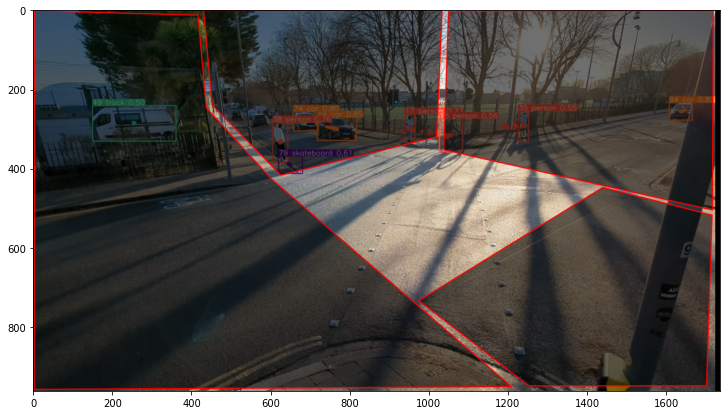

In [52]:
# test_route = entire_routes.loc[entire_routes['det_id'] == 55]['route'].to_list()
# for point in test_route[0]:
#     print(point[0] - STARTTIME, '\t\t', point[1:], '\t\t', which_region(Point(*point[1:])))

    
no_region_points = []
for route in entire_routes['route']:
    for point in route:
        region = which_region(Point(*point[1:]))
        if region is None:
            no_region_points.append(point[1:])
no_region_points

import matplotlib.pyplot as plt
im = plt.imread('route_regions.png')
implot = plt.imshow(im)

# put a blue dot at (10, 20)
for point in no_region_points:
    plt.scatter([point[0]], [point[1]], c='g')

plt.show()

## Apply Filtering Structure

## Add start and end detection timestamps


In [53]:
## Add start and end times of detection for time filtering
route_times_df['start_time'] = route_boundaries_df['start_point'].apply(
    lambda row: row[0],
)
route_times_df['end_time'] = route_boundaries_df['end_point'].apply(
    lambda row: row[0],
)
route_times_df.head()

,label,det_id,start_region,overall_time,start_region_time,end_region_time,no_region_time,end_region,start_time,end_time
0,bicycle,788,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
1,bicycle,789,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
2,bicycle,790,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
3,bicycle,791,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
4,bicycle,792,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00


## Analysis Data formatting

In [54]:
# Main Request Variables
CLASSES = ['person', 'car', 'bicycle', 'hgv']
START_REGIONS = ROUTE_REGIONS
# del START_REGIONS['West_Park_Road']
END_REGIONS = ROUTE_REGIONS

In [55]:
### Sort DataFrame
route_times_df.sort_values(['start_time', 'end_time'], axis=0, inplace=True)
route_times_df.head()

,label,det_id,start_region,overall_time,start_region_time,end_region_time,no_region_time,end_region,start_time,end_time
0,bicycle,788,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
1,bicycle,789,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
2,bicycle,790,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
3,bicycle,791,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
4,bicycle,792,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00


In [56]:
### Data filtering
route_times_df = route_times_df[route_times_df['label'].isin(CLASSES)]
route_times_df.head()

,label,det_id,start_region,overall_time,start_region_time,end_region_time,no_region_time,end_region,start_time,end_time
0,bicycle,788,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
1,bicycle,789,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
2,bicycle,790,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
3,bicycle,791,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00
4,bicycle,792,West_Park_Road,0 days 00:30:00,0 days,0 days,0 days 00:30:00,East_Park_Road,2023-01-20T08:00:00+00:00,2023-01-20T08:30:00+00:00


In [57]:
### Splitting the detections by timestamp intervals
ENDTIME = route_times_df['end_time'].iloc[-1]
print(ENDTIME)

timeBoundaries = [i for i in arrow.Arrow.interval(temporal_resolution, STARTTIME, ENDTIME, intervalSpacing)]
BoundaryEnds = [i[1] for i in timeBoundaries]

print(f"dets: {len(route_times_df)}")

detSplit = [[] for i in range(len(BoundaryEnds))]
currentDet = 0
for boundaryIndex, timeBoundary in enumerate(BoundaryEnds):
    nextBound = False

    for detIndex, det in route_times_df.iloc[currentDet:].iterrows():
        start, end = det['start_time'], det['end_time']

        if start < timeBoundary:
            # if end within time interval or at least has more time in interval
            if end < timeBoundary or timeBoundary - start > end - timeBoundary:
                destInterval = boundaryIndex # Add detection to current interval
            else:
                destInterval = boundaryIndex + 1 # Add detection to next interval
            detSplit[destInterval].append(det)
        else:
            nextBound = True
            break

        currentDet += 1

    if nextBound:
        continue

s = 0
for i in detSplit:
    s += len(i)
print(f"sum: {s}")

print()

2023-01-20T21:30:00+00:00
dets: 1226
sum: 1226



In [58]:
print(detSplit)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [label                                  bicycle
det_id                                     788
start_region                    West_Park_Road
overall_time                   0 days 00:30:00
start_region_time              0 days 00:00:00
end_region_time                0 days 00:00:00
no_region_time                 0 days 00:30:00
end_region                      East_Park_Road
start_time           2023-01-20T08:00:00+00:00
end_time             2023-01-20T08:30:00+00:00
Name: 0, dtype: object, label                                  bicycle
det_id                                     789
start_region                    West_Park_Road
overall_time                   0 days 00:30:00
start_region_time              0 days 00:00:00
end_region_time                0 days 00:00:00
no_region_time                 0 days 00:30:00
end_region                      East_Park_Road
start_time           2023-01-20T08:00:00+00:00
end_time         

In [59]:
timeBoundaries

[(<Arrow [2023-01-20T00:00:00+00:00]>,
  <Arrow [2023-01-20T00:29:59.999999+00:00]>),
 (<Arrow [2023-01-20T00:30:00+00:00]>,
  <Arrow [2023-01-20T00:59:59.999999+00:00]>),
 (<Arrow [2023-01-20T01:00:00+00:00]>,
  <Arrow [2023-01-20T01:29:59.999999+00:00]>),
 (<Arrow [2023-01-20T01:30:00+00:00]>,
  <Arrow [2023-01-20T01:59:59.999999+00:00]>),
 (<Arrow [2023-01-20T02:00:00+00:00]>,
  <Arrow [2023-01-20T02:29:59.999999+00:00]>),
 (<Arrow [2023-01-20T02:30:00+00:00]>,
  <Arrow [2023-01-20T02:59:59.999999+00:00]>),
 (<Arrow [2023-01-20T03:00:00+00:00]>,
  <Arrow [2023-01-20T03:29:59.999999+00:00]>),
 (<Arrow [2023-01-20T03:30:00+00:00]>,
  <Arrow [2023-01-20T03:59:59.999999+00:00]>),
 (<Arrow [2023-01-20T04:00:00+00:00]>,
  <Arrow [2023-01-20T04:29:59.999999+00:00]>),
 (<Arrow [2023-01-20T04:30:00+00:00]>,
  <Arrow [2023-01-20T04:59:59.999999+00:00]>),
 (<Arrow [2023-01-20T05:00:00+00:00]>,
  <Arrow [2023-01-20T05:29:59.999999+00:00]>),
 (<Arrow [2023-01-20T05:30:00+00:00]>,
  <Arrow [2023-

In [60]:
### Split Detections into data-structure with interval stamps

# Separate Detections (dets) by period of time
countsAtTimes = [{'periodFrom'  : from_.float_timestamp, 
            'periodTo'    : to_.float_timestamp,
            'routeCounts' : pd.DataFrame(dets, columns=route_times_df.columns)} \
            for (from_, to_), dets in zip(timeBoundaries, detSplit)]
print(countsAtTimes[0]['routeCounts'])

# Count detection types
def countByClass(df):
    counts = {'total':0}
    for _, row in df.iterrows():
        label = row['label']
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
        counts['total'] += 1
    return counts

# Separate Further into Directional Combinations of Start region and End region for each interval
for interval in countsAtTimes:
    # print(">>> interval:", interval)
    # if interval["routeCounts"].empty:
    #     continue

    routeCounts = interval['routeCounts']
    # Filter detections by their Start and End regions
    routeCounts = routeCounts[
        (routeCounts['start_region'].isin(START_REGIONS)) &
        (routeCounts['end_region'].isin(END_REGIONS))]

    # Split detections by start end region combinations
    detSplit = {}
    for _, det in routeCounts.iterrows():
        start, end = det['start_region'], det['end_region']
        if start == end:
            continue # filter out stationary detections
        elif (start, end) not in detSplit:
            detSplit[(start, end)] = [det]
        else:
            detSplit[(start, end)].append(det)

    routeCounts = []
    # Structure the split detections
    for key, value in detSplit.items():
        df = pd.DataFrame(value, columns=route_times_df.columns)
        routeCounts.append({
            'start': key[0], 
            'end': key[1], 
            'counts': countByClass(df)
        })

    interval['routeCounts'] = routeCounts

# Structure the rest of the json message
dataToSend = {
    "dataSource": "filename",
    "regions": list(ROUTE_REGIONS.keys()),
    "countsAtTimes": countsAtTimes
}

print("countsAtTimes:", countsAtTimes)
# print(detSplit, routeCounts, route_times_df)
import json
dataToSend = json.dumps(dataToSend, indent=4)
print(dataToSend)

Empty DataFrame
Columns: [label, det_id, start_region, overall_time, start_region_time, end_region_time, no_region_time, end_region, start_time, end_time]
Index: []
countsAtTimes: [{'periodFrom': 1674172800.0, 'periodTo': 1674174599.999999, 'routeCounts': []}, {'periodFrom': 1674174600.0, 'periodTo': 1674176399.999999, 'routeCounts': []}, {'periodFrom': 1674176400.0, 'periodTo': 1674178199.999999, 'routeCounts': []}, {'periodFrom': 1674178200.0, 'periodTo': 1674179999.999999, 'routeCounts': []}, {'periodFrom': 1674180000.0, 'periodTo': 1674181799.999999, 'routeCounts': []}, {'periodFrom': 1674181800.0, 'periodTo': 1674183599.999999, 'routeCounts': []}, {'periodFrom': 1674183600.0, 'periodTo': 1674185399.999999, 'routeCounts': []}, {'periodFrom': 1674185400.0, 'periodTo': 1674187199.999999, 'routeCounts': []}, {'periodFrom': 1674187200.0, 'periodTo': 1674188999.999999, 'routeCounts': []}, {'periodFrom': 1674189000.0, 'periodTo': 1674190799.999999, 'routeCounts': []}, {'periodFrom': 1674